In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np 
import pandas as pd 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input,Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D,MaxPooling2D,RandomFlip,RandomZoom,RandomRotation

In [ ]:
from keras.datasets import cifar10

In [ ]:
(x_train, y_train), (x_val, y_val) = cifar10.load_data()

y_train=to_categorical(y_train)
y_val=to_categorical(y_val)

print((x_train.shape, y_train.shape))
print((x_val.shape, y_val.shape))

170508288/170498071 [==============================] - 13s 0us/step
((50000, 32, 32, 3), (50000, 10))
((10000, 32, 32, 3), (10000, 10))


In [ ]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3), classes=y_train.shape[1])

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
data_augmentation = Sequential(
    [RandomFlip("horizontal"), 
     RandomRotation(0.1),
     RandomZoom(0.1)]
)

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224)))(inputs)
x = data_augmentation(x)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation=('softmax'))(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         147146

In [ ]:
def plot_history(history):
    history_frame = pd.DataFrame(history.history)
    history_frame.loc[:, ['loss', 'val_loss']].plot()
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
    
    return

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 14
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, verbose=1)

Epoch 1/14
1563/1563 [==============================] - 775s 483ms/step - loss: 1.1938 - accuracy: 0.5765 - val_loss: 0.6377 - val_accuracy: 0.7839
Epoch 2/14
1563/1563 [==============================] - 752s 481ms/step - loss: 0.6996 - accuracy: 0.7591 - val_loss: 0.4712 - val_accuracy: 0.8370
Epoch 3/14
1563/1563 [==============================] - 754s 483ms/step - loss: 0.5601 - accuracy: 0.8092 - val_loss: 0.4067 - val_accuracy: 0.8622
Epoch 4/14
1563/1563 [==============================] - 757s 484ms/step - loss: 0.4834 - accuracy: 0.8359 - val_loss: 0.3516 - val_accuracy: 0.8835
Epoch 5/14
1563/1563 [==============================] - 756s 484ms/step - loss: 0.4235 - accuracy: 0.8551 - val_loss: 0.3389 - val_accuracy: 0.8851
Epoch 6/14
1563/1563 [==============================] - 756s 484ms/step - loss: 0.3857 - accuracy: 0.8691 - val_loss: 0.2970 - val_accuracy: 0.8988
Epoch 7/14
1563/1563 [==============================] - 754s 482ms/step - loss: 0.3479 - accuracy: 0.8808 - val_

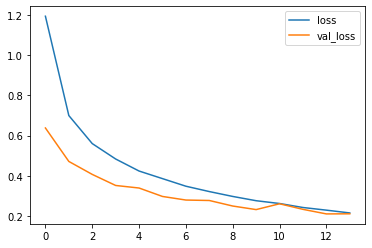

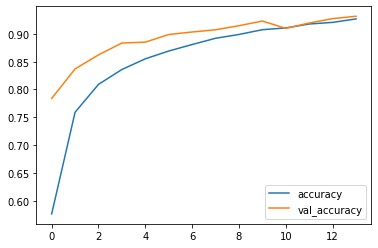

In [ ]:
plot_history(history)

In [ ]:
score = model.evaluate(x_val, y_val, verbose=0) 
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.21069511771202087 / Test accuracy: 0.9315999746322632


In [ ]:
model.save("VGG16_CIFAR-10.h5")

[[Text(0, 0.5, 'airplane'),
  Text(0, 1.5, 'automobile'),
  Text(0, 2.5, 'bird'),
  Text(0, 3.5, 'cat'),
  Text(0, 4.5, 'deer'),
  Text(0, 5.5, 'dog'),
  Text(0, 6.5, 'frog'),
  Text(0, 7.5, 'horse'),
  Text(0, 8.5, 'ship'),
  Text(0, 9.5, 'truck')],
 [Text(0.5, 0, 'airplane'),
  Text(1.5, 0, 'automobile'),
  Text(2.5, 0, 'bird'),
  Text(3.5, 0, 'cat'),
  Text(4.5, 0, 'deer'),
  Text(5.5, 0, 'dog'),
  Text(6.5, 0, 'frog'),
  Text(7.5, 0, 'horse'),
  Text(8.5, 0, 'ship'),
  Text(9.5, 0, 'truck')]]

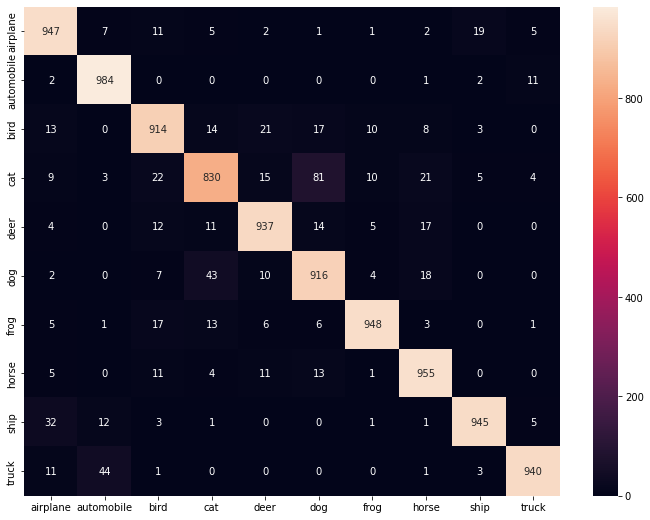

In [ ]:
class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

predictions=model.predict(x_val)

y_pred_classes = np.argmax(predictions, axis=1)
y_true = np.argmax(y_val, axis=1)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 9))
c = sns.heatmap(confusion_mtx, annot=True, fmt='g')
c.set(xticklabels=class_names, yticklabels=class_names)